# CGM Brush Tutorial

In [ ]:
# NOTE: Always clear results before checking in a jupyter notebook. This improves diff's.

import cgmbrush.cgmbrush as cgmb 
import matplotlib.pyplot as plt

%matplotlib inline

# Running Convolutions
Let's briefly walk through creating a Configuration object and running convolutions. This process takes 2D density fields and halo tables from a SimulationProvider and redistributes mass according to a CGMProfile object. It produces a final density field and a variety of other useful data objects for analysis.

In [2]:
# Create a Configuration object and specify details regarding how you'd like to use the library
# Other CGM profiles that are built-in: PrecipitationProfile(), NFWProfile(), TophatProfile(), SphericalTophatProfile(), MassDependentProfile()
config = cgmb.Configuration(cgmb.FireProfile(), 1, resolution=1, provider=cgmb.BolshoiProvider())

# Run the convolutions, taking the density field from the provider above and using the CGM profile specified to create the final density field
# Running the convolution will save off the results in numpy archives in the VAR_FOLDER.
config.run(load_from_files=True) 
# We say load_from_files=True to tell cgmbrush to skip the calculations and just load the results if we've already run this configuration before.

Loading data... Cache miss: precipitation1_256_2022-01-28
Performing Calculations for precipitation1_256_2022-01-28... 

/Users/matt/Dropbox/CGMBrush/cgm-brush/cgmbrush/cgmbrush.py:903: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mtotal = integrate.quad(rhointerp, 0, np.log(XRvir*Rvirkpc))[0]/conv


done


In [3]:
# If this is your first time running this file today, you will notice in the output above that the library tried loading data, but couldn't find it,
# and so it perfomed the calculations. Once these calculation are performed, results are stored in .npy and .npz files.
# Calling run again will effectively no-op.
config.run(load_from_files=True) 

Loading data... done


In [4]:
# Even a new configuration object, set with the same settings, will just find and load the file instead of re-doing calculations.
new_config = cgmb.Configuration(cgmb.FireProfile(), 1, resolution=1, provider=cgmb.BolshoiProvider())
new_config.run(load_from_files=True) 

Loading data... done


In [5]:
# The files that store the results have a datestamp as part of them, which serves as a unique identifier.
# Configuration objects may have a datestamp manually set. This allows you to explicitly reference the data from a run performed,
# which can be helpful if you make algorithmic changes and have multiple versions of similar data.
another_config = cgmb.Configuration(cgmb.FireProfile(), 1, resolution=1, provider=cgmb.BolshoiProvider())
another_config.datestamp = '2021-12-01' 

# This config has a different date than above, so running it will not find the previously saved results.
another_config.run(load_from_files=True)

# Results are saved in your 'var' folder; you can go look at the files generated there. See the readme or settings.py for additional details.

Loading data... Cache miss: precipitation1_256_2021-12-01
Performing Calculations for precipitation1_256_2021-12-01... 

/Users/matt/Dropbox/CGMBrush/cgm-brush/cgmbrush/cgmbrush.py:903: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mtotal = integrate.quad(rhointerp, 0, np.log(XRvir*Rvirkpc))[0]/conv


done


# Let's take a look at the results!


In [6]:

# Since the config object above was already run, the following fields will now be available. 
print(config.get_subtraction_coarse_field().shape)
print(config.get_removed_field().shape)
print(config.get_addition_masks().shape)
print(config.get_addition_field().shape)
print(config.get_final_field().shape)

print(config.get_virial_radii().shape)
print(config.get_halo_masses().shape)


(1, 256, 256)
(1, 256, 256)
(1, 29, 20, 20)
(1, 1024, 1024)
(1, 1024, 1024)
(29,)
(29,)


We can see that the subtraction field is 256 x 256, working at the scale of the original density field from the simulation. The removed field, which is the original field minus the subtraction field, is also 256 x 256. There are 29 addition masks, each 20 x 20 pixels. The addition field, constructed from them, is 1024 x 1024. This is because we set the resolution to 1, and the minimum scale up formula is 1024 x resolution. The final density field is the removed field scaled up and added to the addition field. It is also 1024 x 1024. The first dimension (which is length 1) in the first 5 results is for each redshift that you've run this configuration for. In this case, we have just 1 (which is the default: z=0).

Finally we see that we have 29 virial radii and 29 halo masses, which are the average radii and masses computed for each of the 29 logarithmic mass bins, which comes from a setting in the Configuration.

By the way, if you try to get one of these fields for a configuration that has not yet been run, cgmbrush will run it for you,
store the results, and then return the field asked for. This is a general pattern used in CGMBrush - the getter methods on a configuration will automatically run any code required to get what you want. However, sometimes it is clearer to explicitly run code or load data.

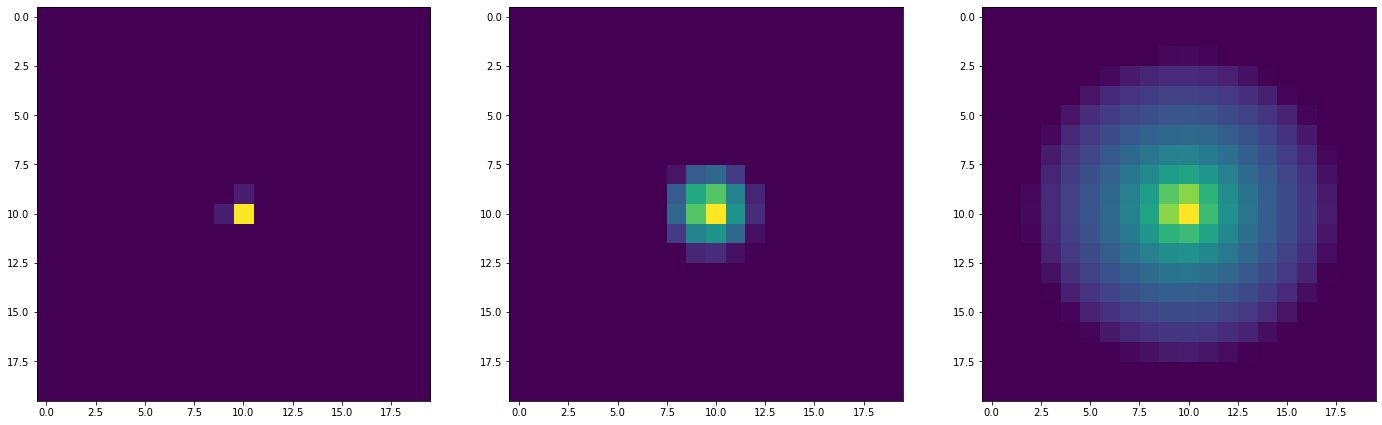

In [7]:
# To get a feel for what CGMBrush did, we can view the masks created from the CGM Profile for each mass bin.
# These are the 2D density profiles that CGMBrush convolved with halo locations.
fig, ax = plt.subplots(1,3,figsize=(24, 8))
ax[0].imshow(config.get_add_mask_for_mass(10**10, 0)) 
ax[1].imshow(config.get_add_mask_for_mass(10**12, 0)) 
ax[2].imshow(config.get_add_mask_for_mass(10**14, 0)) 

# At higher resolutions, the masks are much nicer, but you may need to zoom in to the middle of the image.


In [ ]:
# Let's look at the final density field! 
fig, ax = plt.subplots(1,1,figsize=(16, 16))
ax.imshow(config.get_final_field()[0])

# The [0] selects the first (and only) redshift. The rest is the 2d image data, which is what imshow() expects.


# Other functionality
The final density produced by running the convolution (the `run()` method) is, on it's own, not very helpful for analysis. CGMBrush provides some other functionality useful in understanding how various CGM profiles have affected the distribution of matter.

The first application of this library was the analysis of the dispersion measure (DM) of Fast Radio Bursts (FRBs). Much of the remaining code in this library is geared towards this analysis; for instance, the units that the density maps are in is pc cm^-3, the typical units for DM used by radio astronomers. In the future CGMBrush will make it easier to work with different units and applications. Converstion to other units is, fortunately, trivial.

Let's get into other functionality.

In [8]:
# Generates a radial profile of the density field around halos in each mass bin. Though CGMBrush redistributed mass
# as per the CGMProfile and the halo locations, the overall density field has excess mass in the vicinity of halos, 
# sometimes called the 'two-halo' term. This operation calculates radial profiles from the actual density field and so
# contributions to mass (or DM) implied by the simulation and not the direct CGM profile is included here.

# This operation, like the convolution, is expensive. As such, results are also stored in files. 
# The same filename conventions and caching patterns used for the convolution results are used here as well.
config.generate_DM_vs_radius_profile(load_from_files=True)
print(config.DM_vs_R1[10]) # Print out the radial profile (DM values) for one of the halo masses.
# At higher resolutions the character of the profile can be seen more easily.

# More detailed instructions on how to visualize this coming soon!

Cache miss: precipitation1_256_2022-01-28_DMvsR_prof
Generating DM vs R profile for box 0
[157.99185341 108.1378691   97.5733327   95.03535074  93.20871446
  92.80426176  92.50704162  93.60066722]


/Users/matt/Dropbox/CGMBrush/cgm-brush/cgmbrush/cgmbrush.py:1311: RuntimeWarning: invalid value encountered in true_divide
  DM_mass_bin[i,:,:] = DM_mass_bin[i,:,:] / num_halos # finishing computing average


In [10]:
# This is similar to the above in that a radial profile is calculated. But this time, it is only the mass that was applied
# from the CGM profile - not the full density field (no 'two halo' term)
config.generate_profile_of_masks(load_from_files=True)
print(config.mask_profiles[10]) # Print out the radial profile (DM values) for one of the halo masses.

# More detailed instructions on how to visualize this coming soon!

[53.54470731  5.98809153  0.          0.          0.          0.
  0.          0.        ]
